In [5]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import json
import pandas as pd

In [3]:
best = pd.read_csv("problems/jssp/greedy_solution.csv")

In [ ]:
import numpy as np

def get_scores (path):
    with open(f'ejecuciones/{path}/heuristics_data.json', 'r') as file:
        heuristics_data = json.load(file)
    with open(f'ejecuciones/2025-03-27_17-45-24/heuristics_data.json', 'r') as file:
        heuristics_dataII = json.load(file)
    print(len(heuristics_data))
    for valor in heuristics_data:
        valor['reflection'] = False
    for valor in heuristics_dataII:
        valor['reflection'] = True
    heuristics_data.extend(heuristics_dataII)
    best = pd.read_csv("problems/jssp/greedy_solution.csv")
    epsilon = 0.1

    print(len(heuristics_data))

    scores = {}

    values_per_instance = {}
    for heuristic in heuristics_data:
        if heuristic['evaluation'] not in ['Code Error', 'Infeasible']:
            for instance, evaluation in heuristic['evaluation'].items():
                if instance not in values_per_instance:
                    values_per_instance[instance] = {'Makespan': [], 'Balance': [], 'Separation': []}
                for of_name, of_value in evaluation.items():
                    values_per_instance[instance][of_name].append(of_value)

    for instance, evaluation in heuristic['evaluation'].items():
        for of_name, of_value in evaluation.items():
            values = values_per_instance[instance][of_name]
            values_per_instance[instance][of_name] = {'Mean' : np.mean(values), 'STD': np.std(values)}

    print(len(heuristics_data))
    for heuristic in heuristics_data:
        if heuristic['evaluation'] not in ['Code Error', 'Infeasible']:
            scores[heuristic['id']] = {'id': heuristic['id'], 'Makespan': 0, 'Balance': 0, 'Separation': 0, 'Generation': heuristic['generation'], 'Mean': 0}
            for instance_name, evaluation in heuristic['evaluation'].items():
                for of_name, of_value in evaluation.items():
                        scores[heuristic['id']][of_name] += (-(of_value - values_per_instance[instance_name][of_name]['Mean']) / values_per_instance[instance_name][of_name]['STD']) #el objetivo es minimizar en TODOS
            scores[heuristic['id']]['Makespan'] /= len(heuristic['evaluation'])
            scores[heuristic['id']]['Balance'] /= len(heuristic['evaluation'])
            scores[heuristic['id']]['Separation'] /= len(heuristic['evaluation'])
            scores[heuristic['id']]['Mean'] = (scores[heuristic['id']]['Makespan'] + scores[heuristic['id']]['Balance'] + scores[heuristic['id']]['Separation']) / 3
            scores[heuristic['id']]['Reflection'] = heuristic['reflection']
    return scores

def get_pareto_front(scores):
    pareto_front = []
    
    for _, candidate in scores.items():
        dominated = False
        for _, other in scores.items():
            if all(other[obj] >= candidate[obj] for obj in candidate) and any(other[obj] > candidate[obj] for obj in candidate):
                dominated = True
                break
        if not dominated:
            pareto_front.append(candidate)
    
    return pareto_front

def get_best_in(scores, ofs):
    max_mean = float('-inf')
    for candidate in scores:
        mean = 0
        for of in ofs:
            mean += candidate[of]
        mean /= len(ofs)
        if mean > max_mean:
            max_mean = mean
            best_h = candidate
    return best_h

In [48]:
scores = get_scores('2025-03-27_18-02-26')
pareto_front = get_pareto_front(scores)

130
260


In [46]:
len(scores)

123

In [32]:
reflection = []
noreflection = []
for id, value in scores.items():
    if value['Reflection']:
        reflection.append(value)
    else:
        noreflection.append(value)


In [43]:
len(noreflection)

8

In [36]:
print(get_best_in(pareto_front, ['Balance']))

{'id': 59, 'Makespan': -1.2879392008405348, 'Balance': 1.321380011544259, 'Separation': 0.6710982250931167, 'Generation': 2, 'Mean': 0.23484634526561365, 'Reflection': True}


In [40]:
pareto_generations = [0] * 2
for i, h in scores.items():
    pareto_generations[h['Reflection']] += 1

In [41]:
pareto_generations

[8, 115]

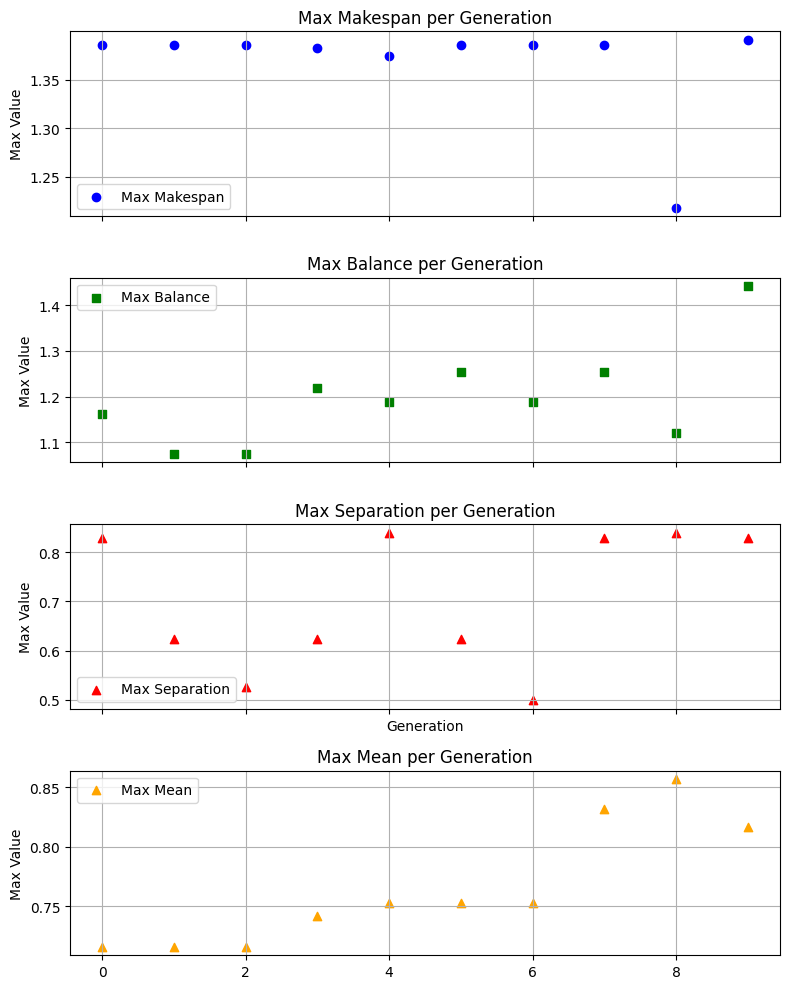

In [16]:
from collections import defaultdict

# Agrupar las métricas por generación
grouped_makespan = defaultdict(list)
grouped_balance = defaultdict(list)
grouped_separation = defaultdict(list)
grouped_means = defaultdict(list)
ids = list(scores.keys())
for g in ids:
    generation = scores[g]['Generation']
    grouped_makespan[generation].append(scores[g]['Makespan'])
    grouped_balance[generation].append(scores[g]['Balance'])
    grouped_separation[generation].append(scores[g]['Separation'])
    grouped_means[generation].append(scores[g]['Mean'])

# Obtener el máximo para cada generación
max_makespan = [max(grouped_makespan[gen]) for gen in sorted(grouped_makespan.keys())]
max_balance = [max(grouped_balance[gen]) for gen in sorted(grouped_balance.keys())]
max_separation = [max(grouped_separation[gen]) for gen in sorted(grouped_separation.keys())]
max_means = [max(grouped_means[gen]) for gen in sorted(grouped_means.keys())]

# Generar el gráfico
fig, axes = plt.subplots(4, 1, figsize=(8, 10), sharex=True)

# Graficar los valores
axes[0].scatter(sorted(grouped_makespan.keys()), max_makespan, marker='o', color='b', label="Max Makespan")
axes[1].scatter(sorted(grouped_balance.keys()), max_balance, marker='s', color='g', label="Max Balance")
axes[2].scatter(sorted(grouped_separation.keys()), max_separation, marker='^', color='r', label="Max Separation")
axes[3].scatter(sorted(grouped_means.keys()), max_means, marker='^', color='orange', label="Max Mean")

# Títulos y etiquetas
axes[0].set_title("Max Makespan per Generation")
axes[1].set_title("Max Balance per Generation")
axes[2].set_title("Max Separation per Generation")
axes[3].set_title("Max Mean per Generation")

# Etiquetas comunes
for ax in axes:
    ax.set_ylabel("Max Value")
    ax.legend()
    ax.grid(True)

axes[2].set_xlabel("Generation")

plt.tight_layout()
plt.show()



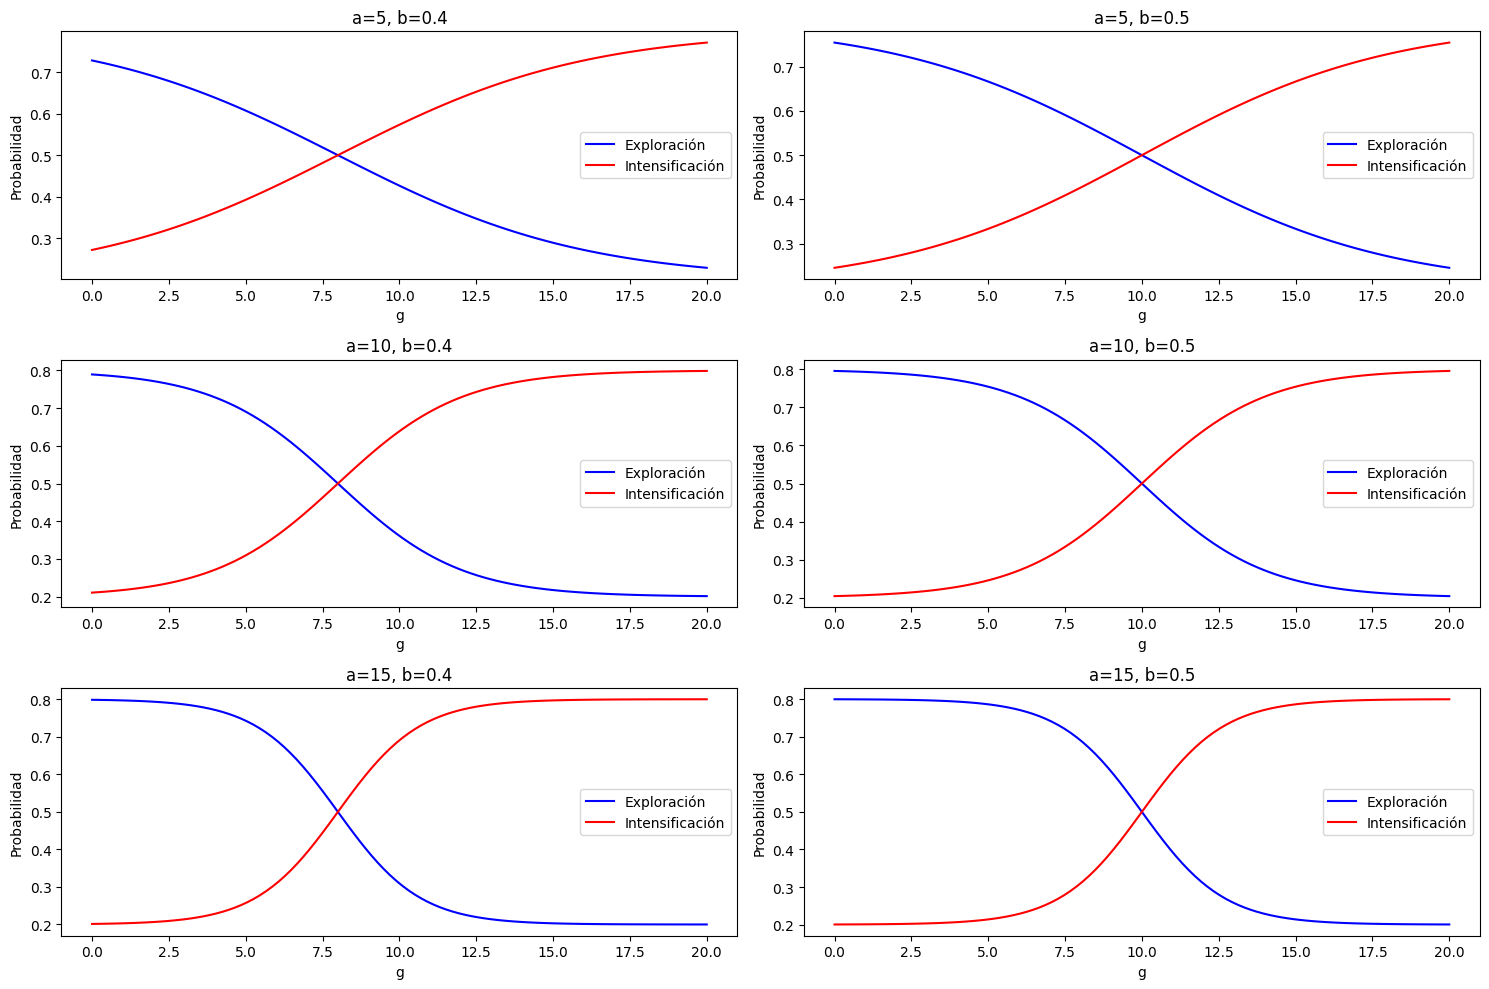

In [78]:
import numpy as np
import matplotlib.pyplot as plt

def ajustar_probabilidades_sigmoide(g, g_max, E_ini=0.8, E_fin=0.2, I_ini=0.2, I_fin=0.8, a=10, b=0.5):
    factor = 1 / (1 + np.exp(a * ((g / g_max) - b)))
    intensificacion = I_ini + (I_fin - I_ini) * (1 - factor)
    exploracion = 1 - intensificacion
    return exploracion, intensificacion
    
def graficar_sigmoides(g_max, a_values, b_values, E_ini, I_ini, I_fin):
    g = np.linspace(0, g_max, 100)  # Rango de valores de g
    
    # Crear subgráficos
    fig, axs = plt.subplots(len(a_values), len(b_values), figsize=(15, 10))
    
    for i, a in enumerate(a_values):
        for j, b in enumerate(b_values):
            exploracion_values = []
            intensificacion_values = []
            
            # Calcular los valores de exploración e intensificación
            for g_val in g:
                exploracion, intensificacion = ajustar_probabilidades_sigmoide(g_val, g_max, a = a, b = b)
                exploracion_values.append(exploracion)
                intensificacion_values.append(intensificacion)
            
            # Graficar
            axs[i, j].plot(g, exploracion_values, label="Exploración", color="blue")
            axs[i, j].plot(g, intensificacion_values, label="Intensificación", color="red")
            axs[i, j].set_title(f'a={a}, b={b}')
            axs[i, j].set_xlabel('g')
            axs[i, j].set_ylabel('Probabilidad')
            axs[i, j].legend()
    
    plt.tight_layout()
    plt.show()

# Ejemplo de uso
graficar_sigmoides(g_max=20, a_values=[5, 10, 15], b_values=[0.4, 0.5], E_ini=0.3, I_ini=0.6, I_fin=0.9,)

In [11]:
from nsga import Individual

individual = Individual('def heuristic():\n while True:\n       a=0\n   return 0', '', '', 'ejecuciones/prueba', 0, 0)


In [ ]:
import threading
import time
import ctypes

def get_solutions(self, instances):
    solutions = {}
    for inst_name, inst_value in instances.items():
        resultado = [None]
        excepcion = [None]

        local_vars = {}
        exec(code, globals(), local_vars)
        heuristic = local_vars['heuristic']

        def run_heuristic():
            try:
                resultado[0] = heuristic(inst_value)
            except Exception as e:
                excepcion[0] = e

        hilo = threading.Thread(target=run_heuristic)
        hilo.start()
        hilo.join(self.max_time)

        if hilo.is_alive():
            ctypes.pythonapi.PyThreadState_SetAsyncExc(
                ctypes.c_long(hilo.ident), ctypes.py_object(SystemExit)
            )
            hilo.join(0.1)

            if hilo.is_alive():
                raise TimeoutError

        if excepcion[0]:
            raise excepcion[0]
        
        solutions[inst_name] = resultado[0]
        
    del local_vars['heuristic']

    return solutions

# Ejemplo de uso
code = """
import time
def heuristic(inst_value):
    print(inst_value)
    time.sleep(1)
    return 4
"""

try:
    resultado = get_solutions(code)
    print(resultado)
except Exception as e:
    print('bien')

9
10
{'mk00': 4, 'mk01': 4}


In [27]:
code = """
import time
def heuristic():
    time.sleep(15)  # Simula un proceso que podría tardar
"""

get_solutions(code)

El script se ejecutó correctamente.


True

In [ ]:
import threading
import time
import ctypes

def get_solutions(code, max_time = 2, instances = {'mk00': 9, 'mk01': 10}):
    solutions = {}
    for inst_name, inst_value in instances.items():
        resultado = [None]
        excepcion = [None]

        local_vars = {}
        exec(code, globals(), local_vars)
        heuristic = local_vars['heuristic']

        def run_heuristic():
            try:
                resultado[0] = heuristic(inst_value)
            except Exception as e:
                excepcion[0] = e

        hilo = threading.Thread(target=run_heuristic)
        hilo.start()
        hilo.join(max_time)

        if hilo.is_alive():
            ctypes.pythonapi.PyThreadState_SetAsyncExc(
                ctypes.c_long(hilo.ident), ctypes.py_object(SystemExit)
            )
            hilo.join(0.1)

            if hilo.is_alive():
                raise TimeoutError

        if excepcion[0]:
            raise excepcion[0]
        
        solutions[inst_name] = resultado[0]
        
    del local_vars['heuristic']

    return solutions

# Ejemplo de uso
code = """
import time
def heuristic(inst_value):
    print(inst_value)
    time.sleep(8)
    return 4
"""

try:
    resultado = get_solutions(code)
except Exception as e:
    print('bien')